In [165]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [166]:
from scripts.get_top_stocks import *
top_stocks_long, top_stocks_long_short = generate_top_stocks_df()
common_top_stocks = get_common_top_stocks(top_stocks_long, top_stocks_long_short)

# specify variables for dataset generation
start_date = '2023-01-01'
end_date = '2024-08-01'
interval = "1h"
trading_days_per_year = 252
hours_per_day = 6.5


Results saved to 'top_30_stocks_long_only.csv' and 'top_30_stocks_long_short.csv'

Detailed metrics for top stock (Long-Only Strategy) SMCI:
Final Close Price: 284.26
60-day Return: 250.61%
Average Hourly Volatility: 0.6678
Average Sharpe Ratio: 1.6242
Average Hourly Volume: 355714

num common_top_stocks:  35


In [167]:
from scripts.generate_dataset_features import *


df = get_all_stock_features_df(
    stocks_list=common_top_stocks,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
    trading_days_per_year=trading_days_per_year, 
    hours_per_day=hours_per_day)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [168]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns,Log_Return_shift,stock_name,Stock_Position,Target,ticker
0,2023-02-24 13:30:00-05:00,169.729996,170.188599,169.139999,170.070007,170.070007,1750690,0.001707,-0.001688,0.116291,...,4.888908,1.510907,-1.967638,-5.354547,-1.09,-0.001000,META,hold,2,META
1,2023-02-24 14:30:00-05:00,170.089996,170.720001,169.610001,169.899994,169.899994,2058333,-0.001000,0.051902,0.080767,...,3.421159,1.422552,-1.854190,-5.170984,-1.09,0.003056,META,hold,2,META
2,2023-02-24 15:30:00-05:00,169.910004,170.490005,169.600006,170.419998,170.419998,2002423,0.003056,0.007657,-0.013768,...,-5.473431,4.507666,-2.691358,-6.412185,-1.09,0.006201,META,buy,3,META
3,2023-02-27 09:30:00-05:00,171.875000,173.119995,170.509995,171.479996,171.479996,4485623,0.006201,0.227990,0.382735,...,-0.901236,-1.610476,-20.280946,-11.763411,0.31,-0.008903,META,sell,1,META
4,2023-02-27 10:30:00-05:00,171.460007,171.630005,169.690002,169.960007,169.960007,2431726,-0.008903,-0.143383,-0.296920,...,1.963164,1.597071,-1.988151,-5.531112,0.31,-0.002356,META,hold,2,META


In [169]:
# additional logic to ensure buy remains +ve and sell remainvs -ve

print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'buy')]))
print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'strong buy')]))

print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'sell')]))
print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'strong sell')]))

# all good

0
0
0
0


In [183]:
df.drop(['Log_Return_shift'], axis=1, inplace=True)
df['Target'] = df['Target'].map({1:0, 2:1, 3:2})
df=df.dropna()

In [203]:
target = 'Target'
features = df.columns[8:-1]
features = features.drop('stock_name')
features = features.drop('Stock_Position')

In [204]:
# sort df according to date
# df1 = df.sort_values("Datetime").reset_index(drop=True)
df1 = df.sort_values("Datetime").reset_index(drop=True)
# train test split on index
train_size, val_size, test_size = 0.8, 0.1, 0.1
train_size, val_size, test_size = int(len(df1) * train_size), int(len(df1) * val_size), int(len(df1) * test_size)
train_df = df1.iloc[:train_size]
val_df = df1.iloc[train_size:train_size + val_size]
test_df = df1.iloc[train_size + val_size:]

train_df.shape,val_df.shape,test_df.shape

((71923, 83), (8990, 83), (8991, 83))

In [205]:
features

Index(['EMAVolumeDiff2', 'SMAVolumeDiff2', 'EMACloseDiff2', 'SMACloseDiff2',
       'VWAP2', 'VolatilityStdDev2', 'Volatility2', 'Momentum2',
       'EMAVolumeDiff4', 'SMAVolumeDiff4', 'EMACloseDiff4', 'SMACloseDiff4',
       'VWAP4', 'VolatilityStdDev4', 'Volatility4', 'Momentum4',
       'EMAVolumeDiff8', 'SMAVolumeDiff8', 'EMACloseDiff8', 'SMACloseDiff8',
       'VWAP8', 'VolatilityStdDev8', 'Volatility8', 'Momentum8',
       'EMAVolumeDiff16', 'SMAVolumeDiff16', 'EMACloseDiff16',
       'SMACloseDiff16', 'VWAP16', 'VolatilityStdDev16', 'Volatility16',
       'Momentum16', 'EMAVolumeDiff32', 'SMAVolumeDiff32', 'EMACloseDiff32',
       'SMACloseDiff32', 'VWAP32', 'VolatilityStdDev32', 'Volatility32',
       'Momentum32', 'EMAVolumeDiff64', 'SMAVolumeDiff64', 'EMACloseDiff64',
       'SMACloseDiff64', 'VWAP64', 'VolatilityStdDev64', 'Volatility64',
       'Momentum64', 'EMAVolumeDiff128', 'SMAVolumeDiff128', 'EMACloseDiff128',
       'SMACloseDiff128', 'VWAP128', 'VolatilityStdDev128'

In [206]:
features_numpy = df[features].to_numpy()
target_numpy = df[target].to_numpy()
# features = features.drop('Target')
X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
print(X_train.shape,y_train.shape)

X_val = val_df[features].to_numpy()
y_val = val_df[target].to_numpy()
print(X_val.shape,y_val.shape)

X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()
print(X_test.shape,y_test.shape)

(71923, 72) (71923,)
(8990, 72) (8990,)
(8991, 72) (8991,)


In [270]:
from scripts.train_predict import *

# standardise the values

scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((71923, 26), (71923,), (8990, 26), (8990,), (8991, 26), (8991,))

In [271]:
X_train

array([[ 1.21402394, -0.60425785,  0.31458423, ...,  0.77524873,
        -0.54992129, -0.62685542],
       [ 0.12140497, -0.9060487 ,  0.82473636, ..., -0.83147304,
         0.49606635, -0.57369211],
       [ 0.98091237, -0.24778102, -0.36882485, ...,  0.95396901,
        -0.21886507, -0.52661596],
       ...,
       [ 0.99789828,  1.39370283, -1.02953092, ...,  1.1323551 ,
         0.70982907, -1.0664509 ],
       [ 0.21818669,  1.47108515, -1.10900963, ..., -0.13848279,
         0.18344024,  0.71178178],
       [ 2.27256314,  2.50027354, -0.22961034, ...,  0.62647904,
         1.35547193,  0.30425301]])

In [272]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm
from alive_progress import alive_it

def train():
    # initialise training params
    best_score = float('inf')
    best_params = None
    best_model = None
    

    # Define the parameter grid
    # param_grid={"learning_rate": (0.05, 0.10, 0.15),
    #             "max_depth": [ 3, 4, 6, 8],
    #             "min_samples_leaf": [0.001, 0.05, 0.1],
    #             "n_estimators": [100, 200, 500]
    #             },
    param_grid = {
        'eta': [0.1, 0.3, 0.5],
        'gamma': [0, ],
        'max_depth': [6, 8],
    }
    # best_model = xgb.XGBClassifier()
    # best_model.fit(X_train, y_train)
    # y_pred = best_model.predict(X_val)
    # best_score = accuracy_score(y_val, y_pred)
    # best_params = 0
    for params in alive_it(ParameterGrid(param_grid)):
        model = xgb.XGBClassifier(**params) # initialise new model before each run
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        
        if score < best_score:
            best_score = score
            best_params = params
            best_model = model
            print(f"score: {round(best_score,7)}")
            # print(f"score: {round(best_score,7)}, params: {best_params}")

    print(f"Best parameters found: {best_params}")
    print(f"Best validation score: {round(best_score,5)}")

    return best_model, best_params, best_score, X_test, y_test

def predict(best_model,X_test, y_test):
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy score: {round(score,5)}")
    
    return y_pred

def train_predict():
    best_model, best_params, best_score, X_test, y_test = train()
    y_pred = predict(best_model, X_test, y_test)
    acc = accuracy_score(y_test, y_pred)
 
    
    return best_model, best_params, best_score, acc, y_pred
    

In [273]:
best_model, best_params, best_score, acc, y_pred = train_predict()

on 0: score: 0.9964405
on 1: score: 0.996218
|████████████████████████████████████████| 6/6 [100%] in 5.6s (1.07/s) 
Best parameters found: {'eta': 0.1, 'gamma': 0, 'max_depth': 8}
Best validation score: 0.99622
Test set accuracy score: 0.99244


In [211]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1927, 1: 5345, 2: 1719}

In [212]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1927, 1: 5345, 2: 1719}

accuracy: 100.0


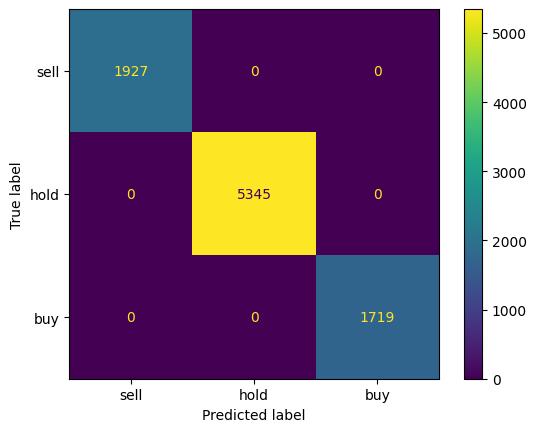

In [214]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f"accuracy: {round(acc*100,2)}")
labels = ['sell', 'hold', 'buy']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [236]:
test_df[test_df['ticker']=='META'].head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,MACD8,MACD16,MACD32,MACD64,MACD128,MACD256,stock_name,Stock_Position,Target,ticker
80915,2024-06-07 09:30:00-04:00,495.000000,495.230011,490.170105,495.000000,495.000000,2670684,0.002407,0.235247,0.374156,...,1.251084,71.779663,14.627730,1.623879,0.449412,0.044208,META,hold,1,META
80975,2024-06-07 10:30:00-04:00,495.109985,498.000000,494.410004,495.855011,495.855011,1168394,0.001726,-0.220872,-0.391315,...,1.163040,5.602493,5.992125,1.527725,0.459228,0.053426,META,hold,1,META
80991,2024-06-07 11:30:00-04:00,495.869995,498.200012,495.814392,498.029999,498.029999,626036,0.004377,-0.317471,-0.302245,...,0.977232,1.851040,2.407476,1.157551,0.420536,0.058633,META,hold,1,META
81037,2024-06-07 12:30:00-04:00,498.040009,498.899902,497.049988,498.257996,498.257996,545128,0.000458,-0.185357,-0.069083,...,2.719679,2.641513,2.816864,1.290797,0.458194,0.069844,META,sell,0,META
81066,2024-06-07 13:30:00-04:00,498.390015,498.529999,492.684998,493.700012,493.700012,959385,-0.009190,0.112145,0.275343,...,-0.103230,-1.118177,-2.857715,16.478032,0.861434,0.108548,META,hold,1,META


In [ ]:
val_df

In [257]:
stock_df = val_df[val_df['stock_name']=='META']
stock_X_test = stock_df[features].to_numpy()
stock_y_test = stock_df[target].to_numpy()
stock_preds = best_model.predict(stock_X_test)
acc = accuracy_score(stock_y_test, stock_preds)
print(acc)

0.8015873015873016


In [255]:
y_val[:100], best_model.predict(X_val)[:100]

(array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], dtype=int64),
 array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], dtype=int64))

In [245]:
accuracy_score(y_val, best_model.predict(X_val))

1.0

In [268]:
agg_y_test = np.array([])
agg_y_pred = np.array([])
avg_acc = 0
for ticker in test_df.stock_name.unique():
    stock_df = test_df[test_df['stock_name']==ticker]
    # print(stock_df.head())
    stock_X_test = stock_df[features].to_numpy()
    stock_y_test = stock_df[target].to_numpy()
    stock_preds = best_model.predict(stock_X_test)
    acc = accuracy_score(stock_y_test, stock_preds)

    print(stock_y_test, stock_preds)

    agg_y_test = np.concatenate((agg_y_test, stock_y_test))
    agg_y_pred = np.concatenate((agg_y_pred, stock_y_test))
    avg_acc += acc
    print(f"{ticker}: {round(acc*100, 2)}")
avg_acc /= len(test_df.stock_name.unique())
print(avg_acc)

[1 2 1 1 1 1 0 1 1 0 2 1 1 0 1 1 1 2 0 1 2 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 2
 2 1 1 2 1 1 2 1 2 1 1 1 2 1 1 1 2 1 0 0 0 0 1 2 2 1 1 1 1 1 0 1 2 2 1 1 1
 1 1 1 1 0 1 1 2 2 0 1 1 0 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 0 0 0 0 1 1 1 0 1
 2 2 1 1 1 1 2 0 1 2 0 2 2 1 1 1 1 2 1 1 2 1 1 1 0 1 1 0 1 1 1 1 0 2 1 0 1
 1 2 1 0 2 1 2 1 2 1 1 1 1 1 0 0 2 1 0 1 1 0 0 0 2 1 0 1 0 0 1 1 1 1 1 0 0
 1 0 2 0 0 1 2 1 1 0 1 1 0 2 1 1 2 2 1 1 1 1 0 1 2 1 1 0 1 0 1 0 0 1 0 1 2
 0 0 0 0 2 1 1 1 0 1 1 1 1 2 1 0 2 1 2 0 1 1 1 1 2 2 1] [1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 2 1 1 2 1 2 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 1 1 1 1 2 1 1 2 1 2 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 2 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1

accuracy: 75.0


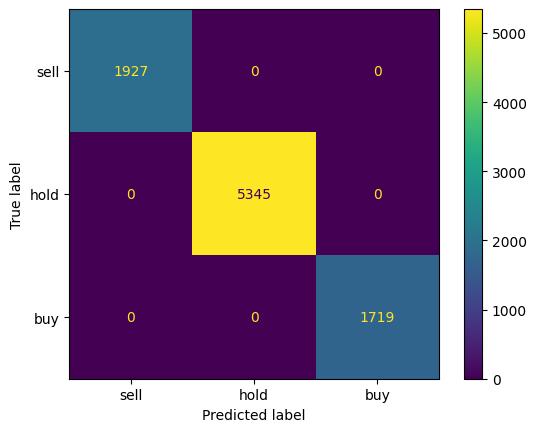

In [262]:
print(f"accuracy: {round(acc*100,2)}")
labels = ['sell', 'hold', 'buy']
cm = confusion_matrix(agg_y_test, agg_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [263]:
confusion_matrix(agg_y_test, agg_y_pred)

array([[1927,    0,    0],
       [   0, 5345,    0],
       [   0,    0, 1719]], dtype=int64)

In [265]:
agg_y_test[:100], agg_y_pred[:100]

(array([1., 2., 1., 1., 1., 1., 0., 1., 1., 0., 2., 1., 1., 0., 1., 1., 1.,
        2., 0., 1., 2., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 2., 2., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 1., 2., 1.,
        1., 1., 2., 1., 0., 0., 0., 0., 1., 2., 2., 1., 1., 1., 1., 1., 0.,
        1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 2., 2., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 0., 1.]),
 array([1., 2., 1., 1., 1., 1., 0., 1., 1., 0., 2., 1., 1., 0., 1., 1., 1.,
        2., 0., 1., 2., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 2., 2., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 1., 2., 1.,
        1., 1., 2., 1., 0., 0., 0., 0., 1., 2., 2., 1., 1., 1., 1., 1., 0.,
        1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 2., 2., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 0., 1.]))

In [223]:
test_df.Target.value_counts()

Target
1    5345
0    1927
2    1719
Name: count, dtype: int64

In [231]:
test_df.stock_name.unique()

array(['CPRT', 'TEAM', 'META', 'DDOG', 'SMCI', 'MELI', 'AMD', 'MRVL',
       'INTU', 'NVDA', 'WDAY', 'TTD', 'CRWD', 'SNPS', 'AVGO', 'MDB',
       'ADBE', 'ZS', 'INTC', 'PANW', 'MSFT', 'PDD', 'BKNG', 'ABNB',
       'AMZN', 'TSLA', 'AMAT', 'MU', 'DASH', 'MKS.L', 'III.L', 'RR.L',
       'MRNA', 'CDNS', 'LRCX'], dtype=object)